In [106]:
import numpy as np
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import sklearn
from functools import partial

In [36]:
n_samp = 3000
rr   = np.random.normal(size=n_samp, scale=0.05, loc=1)
phii = np.random.rand(n_samp)*2*np.pi

xx = np.random.normal(size=3*n_samp, scale=0.3)
yy = np.random.normal(size=3*n_samp, scale=0.3)

In [37]:
arr = np.zeros((2, n_samp))
for idx, (r, phi) in enumerate(zip(rr, phii)):
    arr[:, idx] = [r*np.cos(phi), r*np.sin(phi)]

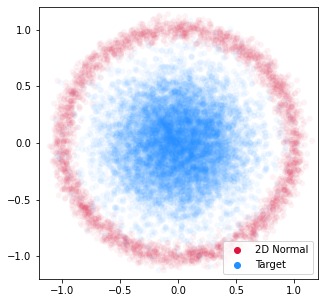

In [44]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(arr[0], arr[1], alpha=0.05,  color='crimson', edgecolor='none')
plt.scatter(xx, yy, alpha=0.05, color='dodgerblue', edgecolor='none')
plt.scatter([], [], label='2D Normal', color='crimson')
plt.scatter([], [], label='Target', color='dodgerblue')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.legend()
plt.show()

In [29]:
xx = np.random.normal(size=n_samp, scale=0.3)
yy = np.random.normal(size=n_samp, scale=0.3)

In [54]:
class NormalizingFlow(nn.Module):

    def __init__(self, latent, flows):
#     def __init__(self, latent: Distribution, flows: List[nn.Module]):
        super(NormalizingFlow, self).__init__()
        self.latent = latent
        self.flows = flows

    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        return self.latent.log_prob(z)

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        return self.latent.sample((num_samples,))

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        '''Sample a new observation x by sampling z from
        the latent distribution and pass through g.'''
        return self.g(self.latent_sample(num_samples))

    def f(self, x: torch.Tensor):
#     def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        '''Maps observation x to latent variable z.
        Additionally, computes the log determinant
        of the Jacobian for this transformation.
        Inveres of g.'''
        z, sum_log_abs_det = x, torch.ones(x.size(0)).to(x.device)
        for flow in self.flows:
            z, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det

        return z, sum_log_abs_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''Maps latent variable z to observation x.
        Inverse of f.'''
        with torch.no_grad():
            x = z
            for flow in reversed(self.flows):
                x = flow.g(x)

        return x

    def g_steps(self, z: torch.Tensor):
#     def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        '''Maps latent variable z to observation x
         and stores intermediate results.'''
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))

        return xs

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        '''Computes log p(x) using the change of variable formula.'''
        z, log_abs_det = self.f(x)
        return self.latent_log_prob(z) + log_abs_det

    def __len__(self) -> int:
        return len(self.flows)

In [56]:
class AffineCouplingLayer(nn.Module):

    def __init__(
       self,
       theta: nn.Module,
       split
#        split: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]
      ):
        super(AffineCouplingLayer, self).__init__()
        self.theta = theta
        self.split = split

    def f(self, x: torch.Tensor) -> torch.Tensor:
        '''f : x -> z. The inverse of g.'''
        x2, x1 = self.split(x)
        t, s = self.theta(x1)
        z1, z2 = x1, x2 * torch.exp(s) + t
        log_det = s.sum(-1)
        return torch.cat((z1, z2), dim=-1), log_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''g : z -> x. The inverse of f.'''
        z1, z2 = self.split(z)
        t, s = self.theta(z1)
        x1, x2 = z1, (z2 - t) * torch.exp(-s)
        return torch.cat((x2, x1), dim=-1)

In [104]:
class Conditioner(nn.Module):

    def __init__(
        self, in_dim: int, out_dim: int,
        num_hidden: int, hidden_dim: int,
        num_params: int
       ):
        super(Conditioner, self).__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList([
                                     nn.Linear(hidden_dim, hidden_dim)
                                     for _ in range(num_hidden)
                                   ])

        self.num_params = num_params
        self.out_dim    = out_dim
        self.dims       = nn.Linear(hidden_dim, out_dim*num_params)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x))
        for h in self.hidden:
            x = F.leaky_relu(h(x))

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1)
        params = batch_params.chunk(self.num_params, dim=-1)
        return [p.squeeze(-1) for p in params]


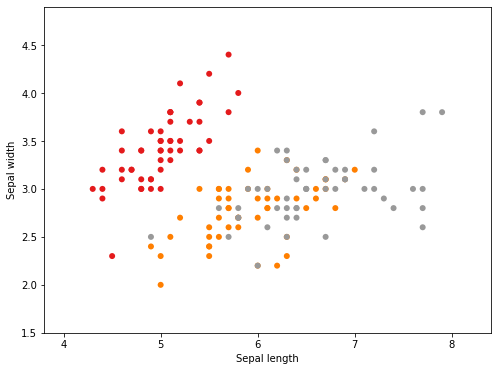

In [69]:
# Load and display the iris dataset

iris = datasets.load_iris()

X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='none')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())

plt.show()

In [93]:
iris = datasets.load_iris(as_frame=True).frame
labels = {0: 'Setosa', 1: 'Versicolour', 2: 'Virginica'}
iris['Species'] = iris.target.apply(lambda c: labels[c])
true_species = torch.from_numpy(iris['target'].values)
iris = iris.drop(columns='target')


In [276]:
def affine_coupling_flows(
    data_dim: int,
    hidden_dim: int,
    num_hidden: int,
    num_params: int,
    num_flows: int,
    device: str
   ) -> nn.Module:
    def flow():
        split = partial(torch.chunk, chunks=2, dim=-1)
        theta = Conditioner(
                            in_dim=data_dim // 2,
                            out_dim=data_dim // 2,
                            num_params=num_params,
                            hidden_dim=hidden_dim,
                            num_hidden=num_hidden
                           )

        return AffineCouplingLayer(theta, split)

    latent = MultivariateNormal(
                                torch.zeros(data_dim).to(device),
                                torch.eye(data_dim).to(device)
                               )
    flows = nn.ModuleList([flow() for _ in range(num_flows)])
    return NormalizingFlow(latent, flows)

In [264]:
def simple_iris_model(device='cpu'):
    return affine_coupling_flows(
                                 data_dim=iris.shape[1]-1,
                                 hidden_dim=100,
                                 num_hidden=1,
                                 num_flows=5,
                                 num_params=2,
                                 device=device
                                ).to(device)

In [265]:
def train(
          model: nn.Module,
          train_loader,
          num_epochs: int,
          args
         ) -> torch.Tensor:

    def _train(epoch, log_interval=50):
        model.train()
        losses = torch.zeros(len(train_loader))
        for i, x in enumerate(train_loader):
            optimizer.zero_grad()
            loss = -model.log_prob(x.to(device)).mean()
            loss.backward()
            losses[i] = loss.item()
            optimizer.step()

        return losses.mean().item()

    def log_training_results(loss, epoch, log_interval):
        if epoch % log_interval == 0:
            print("Training Results - Epoch: {}  Avg train loss: {:.2f}".format(epoch, loss))

    optimizer = torch.optim.AdamW(model.parameters(), lr=args['lr'])
    num_steps = len(train_loader)*num_epochs
    scheduler = StepLR(
                       optimizer,
                       step_size=args['lr_decay_interval'],
                       gamma=args['lr_decay_rate']
                      )

    train_losses = []
    for epoch in range(num_epochs+1):
        loss = _train(epoch)
        log_training_results(loss, epoch, log_interval=100)
        train_losses.append(loss)
        scheduler.step()

    return train_losses


def train_new_model(data, num_epochs, args):
    np.random.seed(1)
    model = simple_iris_model()
    loader = partial(DataLoader, batch_size=32, shuffle=True)
    loss = train(
                 model=model,
                 train_loader=loader(data),
                 num_epochs=num_epochs,
                 args=args
                )

    return model, loss

In [266]:
args={'lr_decay_interval': 400,
        'lr_decay_rate': .3,
        'lr': 1e-3}

def target_class(species) -> torch.Tensor:
    print(species)
    x = iris[iris['Species'] == species].drop(columns='Species')
    return torch.from_numpy(x.values).float()

device = 'cpu'
classes = list(labels.values())
train_with_args = partial(train_new_model, num_epochs=2000, args=args)
model_se, loss_se = train_with_args(target_class(classes[0]))
model_ve, loss_ve = train_with_args(target_class(classes[1]))
model_vi, loss_vi = train_with_args(target_class(classes[2]))

Setosa
4
Training Results - Epoch: 0  Avg train loss: 17.75
Training Results - Epoch: 100  Avg train loss: -1.96
Training Results - Epoch: 200  Avg train loss: -2.94
Training Results - Epoch: 300  Avg train loss: -2.09


KeyboardInterrupt: 

In [151]:
x.size()

torch.Size([150, 4])

In [153]:
def class_probs(x, class_models):
    with torch.no_grad():
      
            
        log_probs = torch.stack([
                                 m.log_prob(x.float())
                                 for m in class_models
                                ])

        log_probs[torch.isnan(log_probs)] = -np.inf
        probs = log_probs.exp()
        probs /= probs.sum(0)
        return probs

def predict(class_probs):
    return class_probs.argmax(0)

def accuracy(y, y_hat):
    return y.eq(y_hat).float().mean().item()

x = torch.from_numpy(iris.iloc[:, :-1].values)
# probs = class_probs(x, class_models=[ model_ve, model_vi])
probs = class_probs(x, class_models=[model_ve, model_vi])
pred_species = predict(probs)
print(f'Model accuracy: {accuracy(true_species, pred_species)}')

Model accuracy: 0.3333333432674408


In [158]:
pred_species

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])

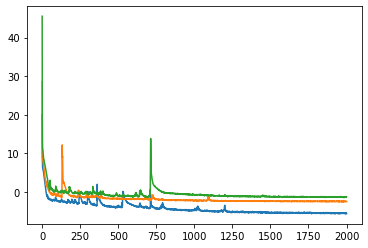

In [126]:
plt.plot(loss_se)
plt.plot(loss_ve)
plt.plot(loss_vi)
plt.show()

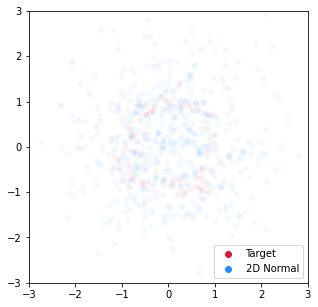

In [336]:
n_samp = 100
rr   = np.random.normal(size=2*n_samp, scale=0.2, loc=1)
phii = np.random.rand(n_samp)*2*np.pi


m    = MultivariateNormal(torch.zeros(2), torch.eye(2))
samp = m.sample(sample_shape=torch.Size([5*n_samp]))

arr = np.zeros((2, n_samp), dtype=float)
for idx, (r, phi) in enumerate(zip(rr, phii)):
    arr[:, idx] = [r*np.cos(phi), r*np.sin(phi)]
    
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(samp[:,0], samp[:,1], alpha=0.05, color='dodgerblue', edgecolor='none')
plt.scatter(arr[0], arr[1], alpha=0.05,  color='crimson', edgecolor='none')
plt.scatter([], [], label='Target', color='crimson')
plt.scatter([], [], label='2D Normal', color='dodgerblue')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend()
plt.show()

In [337]:
target_data = torch.from_numpy(arr.T).float()

def simple_model(device='cpu'):
    return affine_coupling_flows(
                                 data_dim=target_data.size()[1],
                                 hidden_dim=100,
                                 num_hidden=1,
                                 num_flows=5,
                                 num_params=2,
                                 device=device
                                ).to(device)

def train(
          model: nn.Module,
          train_loader,
          num_epochs: int,
          args
         ) -> torch.Tensor:

    def _train(epoch, log_interval=50):
        model.train()
        losses = torch.zeros(len(train_loader))
        for i, x in enumerate(train_loader):
            optimizer.zero_grad()
            loss = -model.log_prob(x.to(device)).mean()
            loss.backward()
            losses[i] = loss.item()
            optimizer.step()

        return losses.mean().item()

    def log_training_results(loss, epoch, log_interval):
        if epoch % log_interval == 0:
            print("Training Results - Epoch: {}  Avg train loss: {:.2f}".format(epoch, loss))

    optimizer = torch.optim.AdamW(model.parameters(), lr=args['lr'])
    num_steps = len(train_loader)*num_epochs
    scheduler = StepLR(
                       optimizer,
                       step_size=args['lr_decay_interval'],
                       gamma=args['lr_decay_rate']
                      )

    train_losses = []
    for epoch in range(num_epochs+1):
        loss = _train(epoch)
        log_training_results(loss, epoch, log_interval=100)
        train_losses.append(loss)
        scheduler.step()

    return train_losses


def train_new_model(data, num_epochs, args):
    np.random.seed(1)
    model = simple_model()
    loader = partial(DataLoader, batch_size=32, shuffle=True)
    loss = train(
                 model=model,
                 train_loader=loader(data),
                 num_epochs=num_epochs,
                 args=args
                )

    return model, loss

In [353]:
args={'lr_decay_interval': 200,
        'lr_decay_rate': .3,
        'lr': 1e-3}

train_with_args = partial(train_new_model, num_epochs=1000, args=args)
model, loss     = train_with_args(target_data)

Training Results - Epoch: 0  Avg train loss: 1.25
Training Results - Epoch: 100  Avg train loss: 0.63
Training Results - Epoch: 200  Avg train loss: 0.63
Training Results - Epoch: 300  Avg train loss: 0.37
Training Results - Epoch: 400  Avg train loss: 0.43
Training Results - Epoch: 500  Avg train loss: 0.38
Training Results - Epoch: 600  Avg train loss: 0.29
Training Results - Epoch: 700  Avg train loss: 0.17
Training Results - Epoch: 800  Avg train loss: 0.12
Training Results - Epoch: 900  Avg train loss: 0.24
Training Results - Epoch: 1000  Avg train loss: 0.24


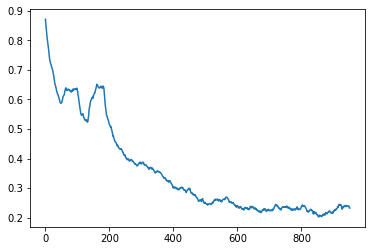

In [359]:
cumsum, moving_aves = [0], []
N = 50

for i, x in enumerate(loss, 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
        #can do stuff with moving_ave here
        moving_aves.append(moving_ave)

plt.plot(moving_aves)

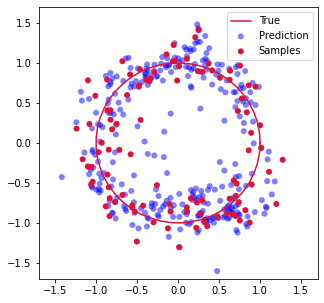

In [360]:
fig, ax = plt.subplots(figsize=(5,5))
prediction = model.sample(num_samples=300)
plt.scatter(prediction[:,0], prediction[:,1], color='blue', edgecolor='none', label='Prediction', alpha=0.5)
plt.scatter(arr[0], arr[1],  color='crimson', edgecolor='none', label='Samples')
plt.plot(np.cos(np.linspace(0,2*np.pi)), np.sin(np.linspace(0,2*np.pi)), label='True', color='crimson')

plt.legend()

plt.xlim(-1.7, 1.7)
plt.ylim(-1.7, 1.7)
plt.show()

# Now let's try on another model

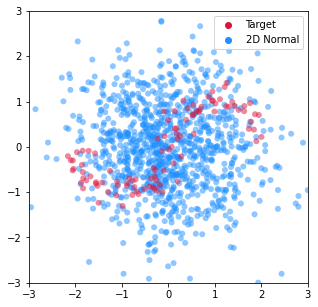

In [404]:
n_samp = 100
rr   = np.random.normal(size=2*n_samp, scale=0.2, loc=1)
phii = np.random.rand(n_samp)*2*np.pi


m    = MultivariateNormal(torch.zeros(2), torch.eye(2))
samp = m.sample(sample_shape=torch.Size([10*n_samp]))

arr = np.zeros((n_samp,2 ), dtype=float)
for idx, (r, phi) in enumerate(zip(rr, phii)):
    if phi>0 and phi<np.pi:
        arr[idx] = [r*np.cos(phi)+1, r*np.sin(phi)]
    else:
        arr[idx] = [r*np.cos(phi)-1, r*np.sin(phi)]


    
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(samp[:,0], samp[:,1], alpha=0.5, color='dodgerblue', edgecolor='none')
plt.scatter(arr[:, 0], arr[:, 1], alpha=0.5,  color='crimson', edgecolor='none')
plt.scatter([], [], label='Target', color='crimson')
plt.scatter([], [], label='2D Normal', color='dodgerblue')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend()
plt.show()

In [394]:
target_data = torch.from_numpy(arr).float()

def less_simple_model(device='cpu'):
    return affine_coupling_flows(
                                 data_dim=target_data.size()[1],
                                 hidden_dim=100,
                                 num_hidden=1,
                                 num_flows=5,
                                 num_params=2,
                                 device=device
                                ).to(device)

def train(
          model: nn.Module,
          train_loader,
          num_epochs: int,
          args
         ) -> torch.Tensor:

    def _train(epoch, log_interval=50):
        model.train()
        losses = torch.zeros(len(train_loader))
        for i, x in enumerate(train_loader):
            optimizer.zero_grad()
            loss = -model.log_prob(x.to(device)).mean()
            loss.backward()
            losses[i] = loss.item()
            optimizer.step()

        return losses.mean().item()

    def log_training_results(loss, epoch, log_interval):
        if epoch % log_interval == 0:
            print("Training Results - Epoch: {}  Avg train loss: {:.2f}".format(epoch, loss))

    optimizer = torch.optim.AdamW(model.parameters(), lr=args['lr'])
    num_steps = len(train_loader)*num_epochs
    scheduler = StepLR(
                       optimizer,
                       step_size=args['lr_decay_interval'],
                       gamma=args['lr_decay_rate']
                      )

    train_losses = []
    for epoch in range(num_epochs+1):
        loss = _train(epoch)
        log_training_results(loss, epoch, log_interval=100)
        train_losses.append(loss)
        scheduler.step()

    return train_losses


def train_new_model(data, num_epochs, args):
    np.random.seed(1)
    model = less_simple_model()
    loader = partial(DataLoader, batch_size=32, shuffle=True)
    loss = train(
                 model=model,
                 train_loader=loader(data),
                 num_epochs=num_epochs,
                 args=args
                )

    return model, loss

In [395]:
args={'lr_decay_interval': 200,
        'lr_decay_rate': .3,
        'lr': 1e-3}

train_with_args = partial(train_new_model, num_epochs=2000, args=args)
model, loss     = train_with_args(target_data)

Training Results - Epoch: 0  Avg train loss: 1.89
Training Results - Epoch: 100  Avg train loss: 0.73
Training Results - Epoch: 200  Avg train loss: 0.60
Training Results - Epoch: 300  Avg train loss: 0.25
Training Results - Epoch: 400  Avg train loss: 0.44
Training Results - Epoch: 500  Avg train loss: 0.42
Training Results - Epoch: 600  Avg train loss: 0.11
Training Results - Epoch: 700  Avg train loss: 0.10
Training Results - Epoch: 800  Avg train loss: 0.28
Training Results - Epoch: 900  Avg train loss: 0.17
Training Results - Epoch: 1000  Avg train loss: 0.28
Training Results - Epoch: 1100  Avg train loss: 0.25
Training Results - Epoch: 1200  Avg train loss: 0.25
Training Results - Epoch: 1300  Avg train loss: 0.26
Training Results - Epoch: 1400  Avg train loss: 0.20
Training Results - Epoch: 1500  Avg train loss: 0.24
Training Results - Epoch: 1600  Avg train loss: 0.14
Training Results - Epoch: 1700  Avg train loss: 0.16
Training Results - Epoch: 1800  Avg train loss: 0.13
Train

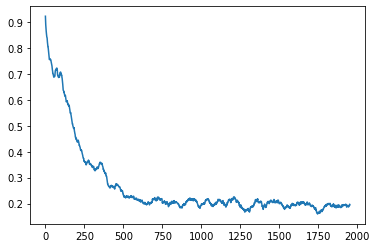

In [396]:
cumsum, moving_aves = [0], []
N = 50

for i, x in enumerate(loss, 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
        #can do stuff with moving_ave here
        moving_aves.append(moving_ave)

plt.plot(moving_aves)
plt.show()

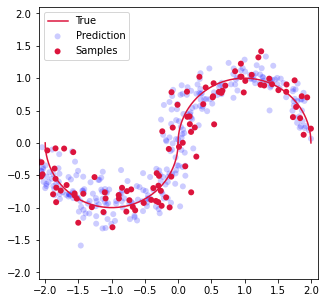

In [403]:
fig, ax = plt.subplots(figsize=(5,5))
prediction = model.sample(num_samples=300)
plt.scatter(prediction[:,0], prediction[:,1], color='blue', edgecolor='none', label='Prediction', alpha=0.2)
plt.scatter(arr[:, 0], arr[:, 1],  color='crimson', edgecolor='none', label='Samples')
plt.plot(np.cos(np.linspace(0,np.pi))+1, np.sin(np.linspace(0, np.pi)), label='True', color='crimson')
plt.plot(np.cos(np.linspace(np.pi, 2*np.pi))-1, np.sin(np.linspace(np.pi, np.pi*2)), color='crimson')

plt.legend()

plt.xlim(-2.1, 2.1)
plt.ylim(-2.1, 2.1)
plt.show()

In [200]:
loc = np.array([1,2])
cov = np.array([[1,0.4],[0.97,1]])
m   = MultivariateNormal(torch.from_numpy(loc).float(), torch.from_numpy(cov).float())

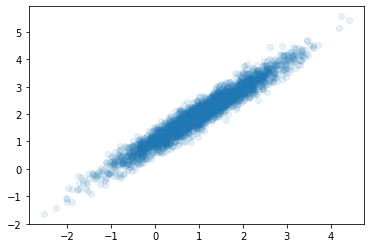

In [201]:
samp = m.sample(sample_shape=torch.Size([3000]))
plt.scatter(samp[:,0], samp[:,1], alpha = 0.1)